# Image Processing with Python: Image Segmentation using RG Chromaticity

by: Jephraim C. Manansala | Published on https://jephraim-manansala.medium.com/

### How to pinpoint and segment objects based on their color chromaticity?

In this post, we will explore how to conduct image segmentation using the RG Chromaticity Space. This post serves as an extension of the image segmentation methods from my previous post.

Let’s begin.

As usual, we import libraries such as `numpy` and `matplotlib`. Additionally, we import specific functions from the `skimage` library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from matplotlib.patches import Rectangle
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)
import warnings 
warnings.filterwarnings('ignore')

But first, what is **chromaticity**? Well, it is the objective specification of the quality of a color regardless of its illumination or the intensity of the color. This can be represented using the **RG Chromaticity Space**, a two-dimensional representation of color chromaticity — wherein the x-axis represents the Red channel, and the y-axis represents the Green channel.

<img src='rg_chromaticity.png' width=400>

Notice how we are only plotting the Red and Green channels in this two-dimensional representation. This is because we will represent the colors with the shade of blue using the absence of the colors Red and Green.

You might ask about the benefits of using the chromaticity space instead of the RGB or HSV color spaces of an image. Certain image processing applications can benefit well from this method — an example of this is skin color. Let’s see how to use this method.

Again, to compare how effective this method is compared to the thresholding method, we will be using this image of a Chico tree with some of its fruits.

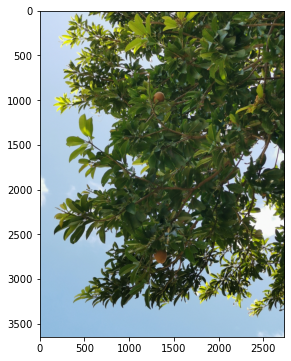

In [2]:
plt.figure(figsize=(6,6))
chico = imread('chico.jpg')
plt.imshow(chico);

Now, let’s see where the colors in this image are in the RG chromaticity space.

Text(0, 0.5, 'Green channel')

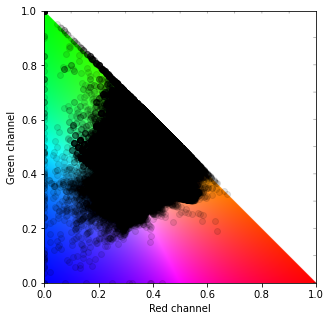

In [3]:
plt.figure(figsize=(5,5))

chico_R = chico[:,:,0]*1.0/chico.sum(axis=2)
chico_G = chico[:,:,1]*1.0/chico.sum(axis=2)

img = plt.imread("rg_chromaticity_noaxis.png")
plt.imshow(img, extent=[0, 1, 0, 1])
plt.scatter(chico_R.flatten(), chico_G.flatten(), color='black', alpha=0.1)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Red channel')
plt.ylabel('Green channel')

Since the colors in the original image range from blue to green to yellow, we can see that the scatter plot points occupied these colors in the RG chromaticity space. From here, we can see which colors are used by the image, and we could also estimate the neighboring colors

Now, to help ease our analysis, I have created the functions that we will be using. These are the following:
1. `rg_chromaticity`, which will return the RG chromaticity values of the specified patch;
2. `mean_and_std`, which will return the mean and standard deviation value of the specified patch;
3. `gaussian`, which will compute the range of colors most similar to the specified patch using a Gaussian distribution,
4. `rg_chromaticity_mask`, which will return the resulting mask based on the specified patch.

In [4]:
def rg_chromaticity(patch):
    return (patch[:,:,0]*1.0 / patch.sum(axis=2), 
            patch[:,:,1]*1.0 / patch.sum(axis=2))

def mean_and_std(patch):
    return  np.mean(patch.flatten()), np.std(patch.flatten())

def gaussian(p, mean, std):
    return np.exp(-(p-mean)**2/(2*std**2))*(1/(std*((2*np.pi)**0.5)))

In [5]:
def rg_chromaticity_mask(image, from_row, from_column, 
                         row_width, column_width, 
                         mean_factor=1, std_factor=1):
    #convert to RG space
    image_R = image[:,:,0]*1.0/image.sum(axis=2)
    image_G = image[:,:,1]*1.0/image.sum(axis=2)
    
    #set the patch value
    image_patch = image[from_column:from_column+column_width, 
                        from_row:from_row+row_width]
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    ax[0].imshow(image)
    ax[0].add_patch(Rectangle((from_row, from_column), 
                              row_width, column_width, 
                              linewidth=3,
                              edgecolor='r', facecolor='none'));
    ax[0].set_title('Original image')
    
    #convert patch to RG space
    patch_R, patch_G = rg_chromaticity(image_patch)

    #get the mean and std of patch
    mean_patch_R, std_patch_R = mean_and_std(patch_R)
    mean_patch_G, std_patch_G = mean_and_std(patch_G)
    
    #get the range of colors of the patch
    prob_R = gaussian(image_R, 
                      mean_factor*mean_patch_R, 
                      std_factor*std_patch_R)
    prob_G = gaussian(image_G, 
                      mean_factor*mean_patch_G, 
                      std_factor*std_patch_G)

    #get the mask
    prob = prob_R * prob_G
    
    #clean the mask using area_opening
    mask = area_opening(prob>0.1)
    ax[1].imshow(mask);
    ax[1].set_title('Mask')
    return mask

Let's use these functions on the Chico fruit!

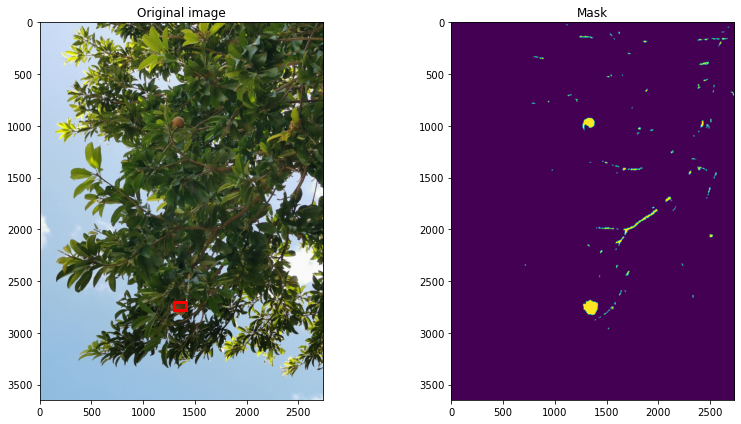

In [6]:
mask_chico = rg_chromaticity_mask(chico, 1300, 2700, 110, 80)
plt.tight_layout()

Notice how effective the RG chromaticity is in segmenting the Chico fruit on the image? The algorithm no longer captures the leaves of the tree. This is a significant improvement compared to the mask created in my previous blog post.

However, since the tree branches are also colored brown, these are also captured by the RG chromaticity algorithm. To address this, we can inspect a bit more and see that the branches’ shade of brownness is different from that of the actual fruit. Therefore, we can vary the standard deviation of the patch values to lessen the neighboring colors that it will capture. Let’s try that!

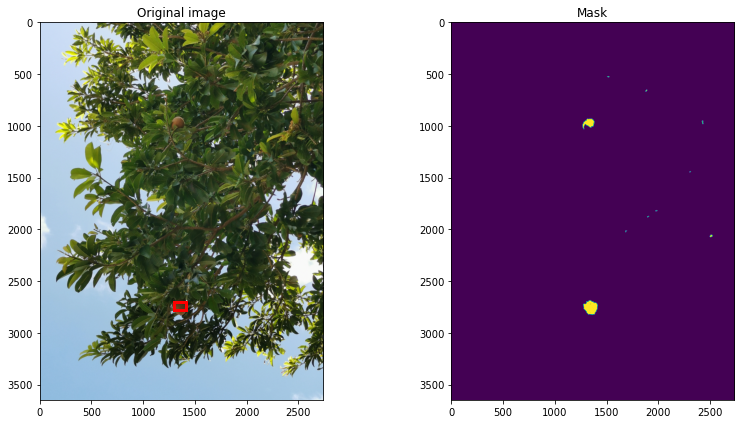

In [7]:
mask = rg_chromaticity_mask(chico, 1300, 2700, 110, 80, 
                            mean_factor=1, std_factor=0.6)
plt.tight_layout()

The masking image is indeed clean! Now, all we need to do is apply this masking image to the original image to get our object of interest. We could also use `regionprops` to determine the properties of this region if our applications require them.

This only shows that the RG chromaticity space can be effective when you have already determined the color shade you will target from the image. However, this example is relatively easy because the contrast between the green leaves and the brown fruit is quite large. So let’s try this method on a much harder image!

Here is an image of a sponge gourd vines and its fruit. Notice how the color of the fruit is almost the same as the colors of the leaves. Let’s try if the RG chromaticity can create the right masking image for this application.

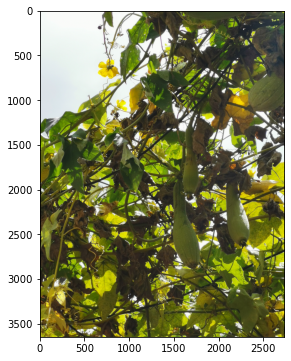

In [8]:
plt.figure(figsize=(6,6))
patola = imread('patola.jpg')
plt.imshow(patola);

By applying RG chromaticity on the patch of fruit, we have:

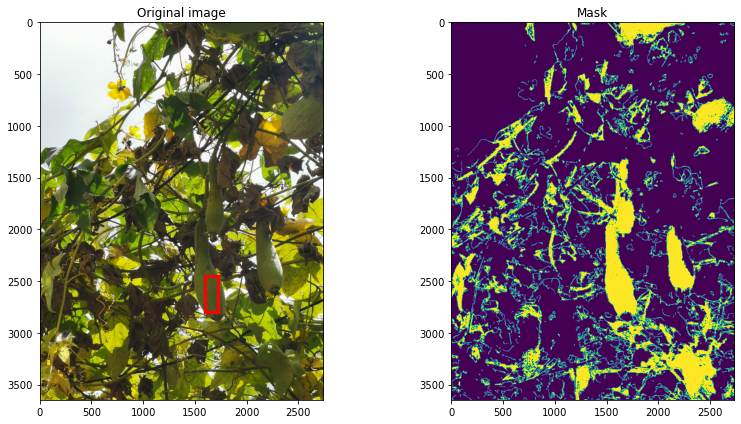

In [9]:
mask = rg_chromaticity_mask(patola, 1600, 2450, 120, 350)
plt.tight_layout()

Notice how even though the image is still uncleaned, the masking image was still able to pinpoint and detect the fruits! This only shows that it can detect objects even though the colors are approximately the same as the other objects in the image.

The only thing left to do is to clean this image using morphological operations!

In [10]:
element = np.array([[0,1,1,0],
                   [1,1,1,1],
                   [1,1,1,1],
                   [0,1,1,0]])

def multi_dil(im, num, element=element):
    for i in range(num):
        im = dilation(im, element)
    return im

def multi_ero(im, num, element=element):
    for i in range(num):
        im = erosion(im, element)
    return im

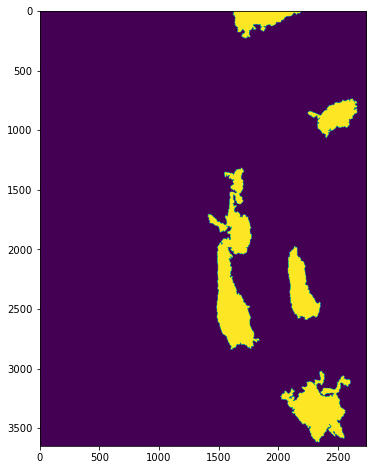

In [11]:
plt.figure(figsize=(8,8))
area_opened = area_opening(mask, 50000)
multi_eroded = multi_ero(area_opened, 3)
opened = area_opening(multi_eroded, 35000)
multi_dilated = multi_dil(opened, 3)
closed = area_closing(multi_dilated, 35000)
plt.imshow(closed)

We have successfully created a masking image that focuses on the five fruits in the image by applying morphological operations. However, we have also captured a leaf in the masking image because its colors are close to the fruit. But no worries! Since the image is already clean, this unnecessary object can easily be removed using `regionprops`. I guess we can use the `major_axis_length` and `minor_axis_length` properties to filter the leaf in the masking image — but I’m going to leave that for you to do!

Overall, the examples presented here only prove that indeed, the RG chromaticity space can be used to create a good masking image even though the difference in color shades is really tight!

#### In summary

We have explored how to segment images using the RG Chromaticity method properly. Given a color patch of an object in the image, we can detect all regions in the original image that is approximately the same as the color patch. Moreover, we have explored how we can further adjust the mean value and standard deviation value to filter out colors of similar shade further.

Segmenting images using the RG Chromaticity method is indeed a powerful tool in image processing. I believe that this one of the methods you need to master to help you develop your image processing projects!

